# Tópicos de Minería de datos - TP 1
## Autora: Aldana Zarate

La siguiente celda y los %%R en cada celda de código fue porque renegué mucho para hacer andar R en mi pc y en colab y fue la manera que conseguí poder ejecutar el código, para el TP2 va a estar más prolijo.

In [1]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("caret")
library(caret)

In [3]:
%%R
library(MASS)
library(ggplot2)
library(caret)
library(rpart)
library(class)

## Ejercicios 1 y 2
## a)


In [4]:
%%R

generate_dataframe <- function(center1, center2, std_dev, d, n){
    cov_matrix = diag(rep(std_dev, times=d))
    points0 = mvrnorm(floor(n / 2), center1, cov_matrix)
    points1 = mvrnorm(ceiling(n / 2), center2, cov_matrix)
    clase0 = cbind(points0, rep(0, times=floor(n / 2)))
    clase1 = cbind(points1, rep(1, times=ceiling(n / 2)))
    return(as.data.frame(rbind(clase0, clase1)))
}

generate_diagonal <- function(n, d, C){
    generate_dataframe(rep(-1, times=d), rep(1, times=d), C * sqrt(d), d, n)
}

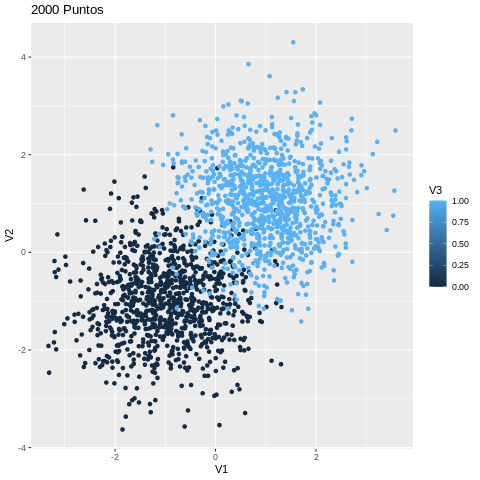

In [5]:
%%R
data = generate_diagonal(2000, 2, 0.5)
ggplot(data,
       aes(x=V1,
           y=V2,
           color = V3)) +
  geom_point() +
  labs(title = "2000 Puntos")

## b)


In [6]:
%%R
curva1 <- function(theta){
  return(theta / (4 * pi))
}

curva2 <- function(theta){
  return((theta + pi) / (4 * pi))
}

In [7]:
%%R
generate_spirals <- function(n){
  cant_0 = 0
  cant_1 = 0

  total_cant_0 = floor(n / 2)
  total_cant_1 = n - total_cant_0

  clase = vector()
  coords_x = vector()
  coords_y = vector()

  while(cant_0 < total_cant_0 || cant_1 < total_cant_1){
    theta = 2 * pi * runif(1, min=0, max=1)
    r = sqrt(runif(1, min=0, max=1))

    betweenCurves = FALSE

    for(i in seq(-1,5)){
      theta0 = theta + (2 * pi * i)
      if(curva1(theta0) < r && r < curva2(theta0)){
          if(cant_0 < total_cant_0){
            cant_0 = cant_0 + 1
            coords_x = append(coords_x, r * cos(theta))
            coords_y = append(coords_y, r * sin(theta))

            clase = append(clase, 0)
          }
          betweenCurves = TRUE
      }
    }

    if (cant_1 < total_cant_1 && !betweenCurves) {
      cant_1 = cant_1 + 1
      coords_x = append(coords_x, r * cos(theta))
      coords_y = append(coords_y, r * sin(theta))

      clase = append(clase, 1)
    }

  }

  return(as.data.frame(cbind(coords_x, cbind(coords_y, clase))))

}

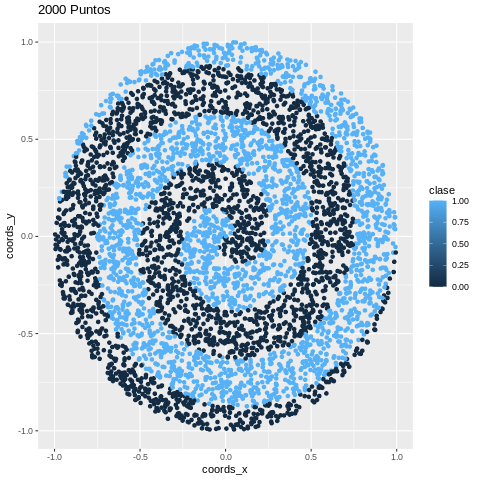

In [8]:
%%R
data = generate_spirals(5000)
ggplot(data,
       aes(x=coords_x,
           y=coords_y,
           color = clase)) +
  geom_point() +
  labs(title = "2000 Puntos")

## Ejercicio 3)
### Árboles de decisión
Sin folds

In [9]:
%%R
arboles_sin_fold <- function(){
    # Conjuntos de train y test
    # Diagonal
    diagonal_train = generate_diagonal(200, 2, 0.5)
    diagonal_test = generate_diagonal(2000, 2, 0.5)
    # Espirales
    spiral_train = generate_spirals(200)
    spiral_test = generate_spirals(2000)

    # Entrenamiento

    clf_d <- rpart(V3~., data=diagonal_train, method='class')
    clf_s <- rpart(clase~., data=spiral_train, method='class')

    # Probamos sobre los conjuntos de testeo

    predicted_d <- predict(clf_d, diagonal_test[-3], type='class')
    predicted_s <- predict(clf_s, spiral_test[,-3], type='class')

    # Guardamos errores sobre el conjunto de testeo.
    # Error = 1 - accuracy

    matrix_gain_diagonal <- table(predicted_d, diagonal_test[,3])
    accuracy_gain_diagonal <- sum(diag(matrix_gain_diagonal)) / sum(matrix_gain_diagonal)

    # Error espirales

    matrix_gain_spiral <- table(predicted_s, spiral_test[,3])
    accuracy_gain_spiral <- sum(diag(matrix_gain_spiral)) / sum(matrix_gain_spiral)
    1 - accuracy_gain_spiral

    return(c(1 - accuracy_gain_diagonal, 1 - accuracy_gain_spiral))
}

Con folds


In [10]:
%%R
arboles_con_fold <- function(){

    diagonal_train = generate_diagonal(200, 2, 0.5)
    spiral_train = generate_spirals(200)

    # Creamos los folds
    k = 5
    folds_data_diagonal = createFolds(t(diagonal_train[, 'V3']), k=k)
    folds_data_spiral = createFolds(t(spiral_train[, 'clase']), k=k)

    errors_diagonal = c()
    errors_spiral = c()

    for(i in 1:k){
        # Conjuntos de entrenamiento y test

        diagonal_train_k = diagonal_train[setdiff(seq(1 : dim(diagonal_train)[1]), folds_data_diagonal[[i]]) , ]
        diagonal_test_k = diagonal_train[folds_data_diagonal[[i]] , ]

        spiral_train_k = spiral_train[setdiff(seq(1 : dim(spiral_train)[1]), folds_data_spiral[[i]]) , ]
        spiral_test_k = spiral_train[folds_data_spiral[[i]] , ]

        # Entrenamiento

        clf_d_k <- rpart(V3~., data=diagonal_train_k, method='class')
        clf_s_k <- rpart(clase~., data=spiral_train_k, method='class')

        # Probamos sobre los conjuntos de testeo

        predicted_d_k <- predict(clf_d_k, diagonal_test_k[-3], type='class')
        predicted_s_k <- predict(clf_s_k, spiral_test_k[,-3], type='class')

        # Guardamos errores sobre el conjunto de testeo.
        # Error = 1 - accuracy

        matrix_gain_diagonal_k <- table(predicted_d_k, diagonal_test_k[,3])
        accuracy_gain_diagonal_k <- sum(diag(matrix_gain_diagonal_k)) / sum(matrix_gain_diagonal_k)
        errors_diagonal[i] = 1 - accuracy_gain_diagonal_k

        matrix_gain_spiral_k <- table(predicted_s_k, spiral_test_k[,3])
        accuracy_gain_spiral_k <- sum(diag(matrix_gain_spiral_k)) / sum(matrix_gain_spiral_k)
        errors_spiral[i] = 1 - accuracy_gain_spiral_k
    }

    error_diagonal = sum(errors_diagonal) / k
    error_spiral = sum(errors_spiral) / k

    return(c(error_diagonal, error_spiral))

}

In [11]:
%%R
tree_train_no_folds = arboles_sin_fold()
trees_train_folds = arboles_con_fold()
df <- data.frame(
    'Dataset'=c('Diagonal', 'Espirales'),
    'Error_sin_fold'=c(tree_train_no_folds[1], tree_train_no_folds[2]),
    'Error_con_5fold'=c(trees_train_folds[1], trees_train_folds[2])
    )
df

    Dataset Error_sin_fold Error_con_5fold
1  Diagonal           0.08           0.095
2 Espirales           0.27           0.365


## K-vecinos
Sin fold


In [12]:
%%R
knn_sin_fold <- function(){

    # Datos para ajustar los modelos y de test

    diagonal_train = generate_diagonal(200, 2, 0.5)
    diagonal_test = generate_diagonal(2000, 2, 0.5)
    diagonal_train_target = diagonal_train[, 3]
    diagonal_test_target = diagonal_test[, 3]

    spiral_train = generate_spirals(200)
    spiral_test = generate_spirals(2000)
    spiral_train_target = spiral_train[, 3]
    spiral_test_target  = spiral_test[, 3]

    # Entrenamos los modelos

    knn_d <- knn(diagonal_train[, -3], diagonal_test[-3], cl=diagonal_train_target, k=3)
    knn_s <- knn(spiral_train[, -3], spiral_test[, -3], cl=spiral_train_target, k=3)

    table_diagonal = table(knn_d, diagonal_test_target)
    knn_error_d = 1 - (sum(diag(table_diagonal)) / sum(table_diagonal))

    table_spiral = table(knn_s, spiral_test_target)
    knn_error_s = 1 - (sum(diag(table_spiral)) / sum(table_spiral))

    return(c(knn_error_d, knn_error_s))

}

Con fold

In [13]:
%%R
knn_con_fold <- function(){

    # Creamos los folds

    diagonal_train = generate_diagonal(200, 2, 0.5)
    spiral_train = generate_spirals(200)

    k = 5
    folds_data_diagonal = createFolds(t(diagonal_train[, 'V3']), k=k)
    folds_data_spiral = createFolds(t(spiral_train[, 'clase']), k=k)

    errors_diagonal = c()
    errors_spiral = c()

    for(i in 1:k){
        # Conjuntos de entrenamiento y test

        diagonal_train_k = diagonal_train[setdiff(seq(1 : dim(diagonal_train)[1]), folds_data_diagonal[[i]]) , ]
        diagonal_test_k = diagonal_train[folds_data_diagonal[[i]] , ]
        diagonal_train_target = diagonal_train_k[, 3]
        diagonal_test_target = diagonal_test_k[, 3]

        spiral_train_k = spiral_train[setdiff(seq(1 : dim(spiral_train)[1]), folds_data_spiral[[i]]) , ]
        spiral_test_k = spiral_train[folds_data_spiral[[i]] , ]
        spiral_train_target = spiral_train_k[, 3]
        spiral_test_target  = spiral_test_k[, 3]

        # Entrenamiento

        knn_d <- knn(diagonal_train_k[, -3], diagonal_test_k[-3], cl=diagonal_train_target, k=3)
        knn_s <- knn(spiral_train_k[, -3], spiral_test_k[, -3], cl=spiral_train_target, k=3)

        # Error

        table_diagonal = table(knn_d, diagonal_test_target)
        knn_error_diagonal = 1 - (sum(diag(table_diagonal)) / sum(table_diagonal))
        errors_diagonal[i] = knn_error_diagonal

        table_spiral = table(knn_s, spiral_test_target)
        knn_error_spiral = 1 - (sum(diag(table_spiral)) / sum(table_spiral))
        errors_spiral[i] = knn_error_spiral
    }

    error_diagonal = sum(errors_diagonal) / k
    error_spiral = sum(errors_spiral) / k

    return(c(error_diagonal, error_spiral))
}

In [14]:
%%R
knn_sin = knn_sin_fold()
knn_con = knn_con_fold()

df <- data.frame(
    'Dataset'=c('Diagonal', 'Espirales'),
    'Error_sin_fold'=c(knn_sin[1], knn_sin[2]),
    'Error_con_5fold'=c(knn_con[1], knn_con[2])
    )
df

    Dataset Error_sin_fold Error_con_5fold
1  Diagonal         0.0580           0.055
2 Espirales         0.1385           0.210


## Conclusiones

En árboles, para el caso del problema diagonal tanto los resultados obtenidos con y sin folds son muy parecidos y no están mal. Sin embargo, no sucede lo mismo para el problema de las espirales, ya que observamos errores mucho mayores, y en el caso de fold cross-validation, aún un 10% más.

En k-vecinos, los resultados son muy similares. En el problema diagonal se observan errores prácticamente iguales usando o no folds, y dichos errores son aceptables. Para el problema de las espirales observamos errores más bajos que en árboles, pero el aumento del error notoriamente y la diferencia del 10% más usando folds se mantiene.

Como los datos no tienen ruido y por lo observado, para este caso el modelo de knn se comporta ligeramente mejor que el de los árboles de decisión, pero ninguno de los 2 se comporta de manera demasiado aceptable para el problema de las espirales.